In [ ]:
from google.colab import files
uploaded = files.upload()


Saving 3class-Dataset-20250723T140231Z-1-001.zip to 3class-Dataset-20250723T140231Z-1-001.zip


In [ ]:
import zipfile
import os

zip_path = '3class-Dataset-20250723T140231Z-1-001.zip'
extract_dir = './3class-Dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extracted to:", extract_dir)


Extracted to: ./3class-Dataset


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import pandas as pd
from torchvision.models.vision_transformer import vit_b_16

In [ ]:
inner_dirs = [os.path.join(extract_dir, d) for d in os.listdir(extract_dir)]
actual_root = [d for d in inner_dirs if os.path.isdir(d) and 'train' in os.listdir(d)][0]
train_dir = os.path.join(actual_root, 'train')
test_dir = os.path.join(actual_root, 'test')

labels_dict = {'AD': 0, 'CI': 1, 'CN': 2}

In [ ]:
class MRIDataset(Dataset):
    def __init__(self, data_dir, labels_dict, transform=None):
        self.data = []
        self.labels_dict = labels_dict
        self.transform = transform

        # Traverse the class folders inside data_dir
        for label_name in os.listdir(data_dir):
            label_path = os.path.join(data_dir, label_name)
            if os.path.isdir(label_path):
                for img_name in os.listdir(label_path):
                    img_path = os.path.join(label_path, img_name)
                    self.data.append((img_path, labels_dict[label_name]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = MRIDataset(train_dir, labels_dict, transform)
test_dataset = MRIDataset(test_dir, labels_dict, transform)

print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=16)


Train size: 4187
Test size: 1048


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torchvision.models.vision_transformer import ViT_B_16_Weights
model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
model.heads.head = nn.Linear(model.heads.head.in_features, 3)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4,weight_decay=0.01)



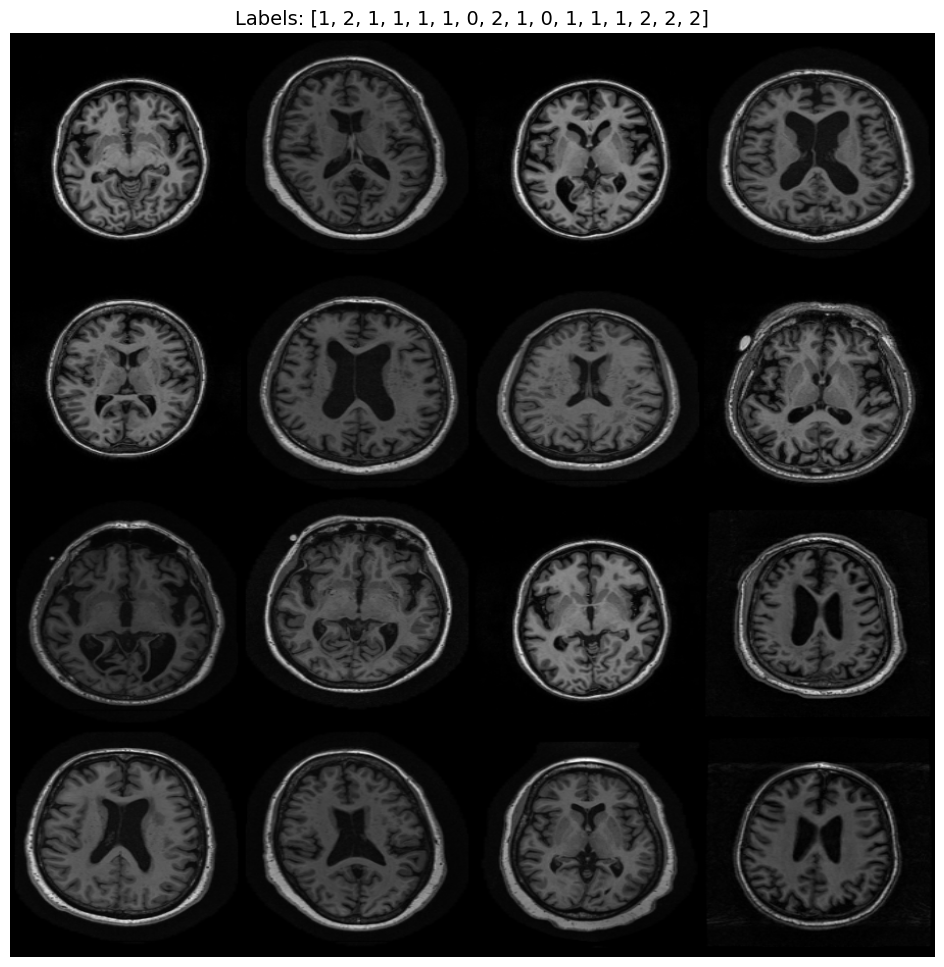

In [ ]:
from PIL import Image
import torchvision
images, labels = next(iter(train_loader))

grid_img = torchvision.utils.make_grid(images, nrow=4, padding=2)

plt.figure(figsize=(24, 12))
plt.imshow(grid_img.permute(1, 2, 0))
plt.title(f"Labels: {labels.tolist()}", fontsize=14)
plt.axis('off')
plt.show()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


In [ ]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(5):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print("One batch trained.")
        # break
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    if total > 0:
        train_accuracies.append(100. * correct / total)
    else:
       train_accuracies.append(0)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    if val_total > 0:
        val_accuracies.append(100. * val_correct / val_total)
    else:
       val_accuracies.append(0)


    print(f"📊 Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Train Acc={train_accuracies[-1]:.2f}%, Val Loss={val_losses[-1]:.4f}, Val Acc={val_accuracies[-1]:.2f}%")


📊 Epoch 1: Train Loss=1.0370, Train Acc=48.39%, Val Loss=1.1624, Val Acc=47.52%
📊 Epoch 2: Train Loss=0.6369, Train Acc=74.04%, Val Loss=1.4956, Val Acc=37.69%
📊 Epoch 3: Train Loss=0.2288, Train Acc=91.71%, Val Loss=1.8823, Val Acc=47.52%
📊 Epoch 4: Train Loss=0.1126, Train Acc=95.94%, Val Loss=2.5486, Val Acc=49.62%
📊 Epoch 5: Train Loss=0.0651, Train Acc=97.73%, Val Loss=2.3388, Val Acc=60.21%


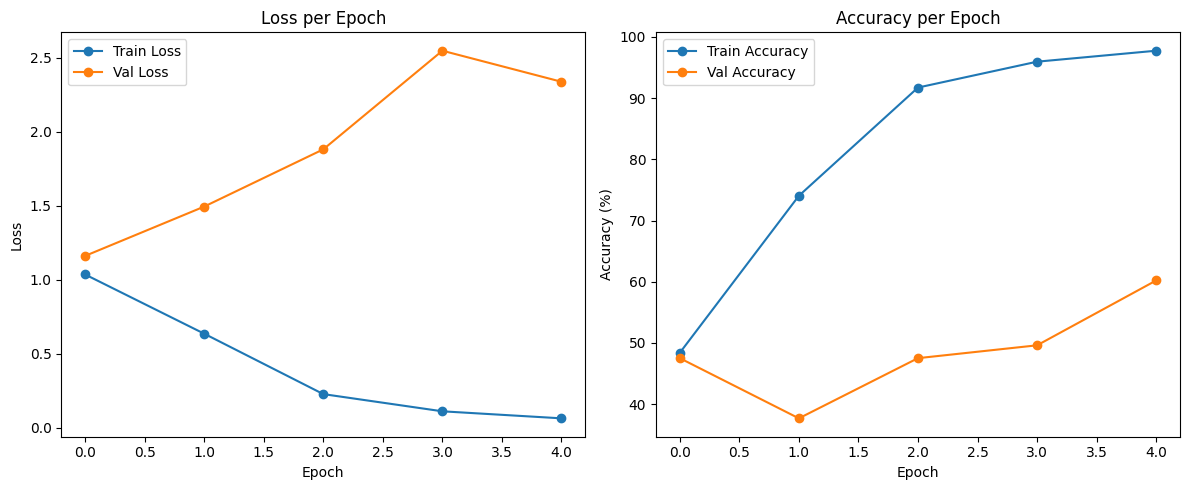

In [ ]:
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='o')
plt.title('Loss per Epoch'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Val Accuracy', marker='o')
plt.title('Accuracy per Epoch'); plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.legend()

plt.tight_layout()
plt.show()
